In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set(style="ticks")
np.set_printoptions(precision=3, suppress=True, threshold=5)
pd.set_option('display.precision', 3)
pd.set_option('display.max_rows', None)  # Show all rows

# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

color_palette = sns.color_palette('muted', 5)
color_palette[2] = '#009E73'

In [2]:
def load_data(patterns, metric):
    dfs = []
    for pattern in patterns:
        files = glob.glob(pattern)
        files.sort()
        for fname in files:
            setting = fname.split('/eval_')[1].replace('.json', '').split('_')

            df = pd.read_json(fname, orient='index').transpose()
            df['seed'] = int(setting[0])
            df['runs'] = int(setting[1])
            df['noise'] = float(setting[2])

            df['method'] = setting[3]
            horizon = setting[4].split('-')
            df['ph'] = int(horizon[0])
            df['ah'] = int(horizon[1])

            # Set default values
            df['nsample'] = 1
            df['nmode'] = 1
            df['decay'] = np.nan

            if setting[3] == 'coherence':
                df['nsample'] = int(setting[5])
                df['decay'] = float(setting[6])
            elif setting[3] in ['positive']:
                df['nsample'] = int(setting[5])
                df['nmode'] = int(setting[6])
            elif setting[3] in ['contrast', 'positive', 'negative']:
                df['nsample'] = int(setting[5])
                df['nmode'] = int(setting[6])
            elif setting[3] == 'bid':
                df['nsample'] = int(setting[5])
                df['nmode'] = int(setting[6])
                df['decay'] = float(setting[7])
            elif setting[3] in ['cma', 'cwarm']:
                df['nsample'] = int(setting[5])
                df['decay'] = float(setting[6])
            elif setting[3] == 'ema':
                df['decay'] = float(setting[5])

            dfs.append(df)
    
    dff = pd.concat(dfs, ignore_index=True)
    dff['decay'] = dff['decay'].astype(float)
    dff['nsample'] = dff['nsample'].astype(int)
    dff['nmode'] = dff['nmode'].astype(int)
    dff['runs'] = dff['runs'].astype(int)
    dff[metric] = dff[metric].astype(float)
    
    method_order = {'random': 0, 'warmstart': 0.8, 'ema': 1, 'bid': 2}
    dff['sort_key'] = dff['method'].apply(lambda x: method_order.get(x.lower(), len(method_order)))
    
    dff = dff.sort_values(['noise', 'ah', 'sort_key', 'method', 'nsample', 'decay', 'nmode', 'seed', metric]).drop('sort_key', axis=1)
    cols = ['noise', 'ah', 'method', 'nsample', 'decay', 'nmode', 'seed', metric]

    dff = dff[cols]

    return dff

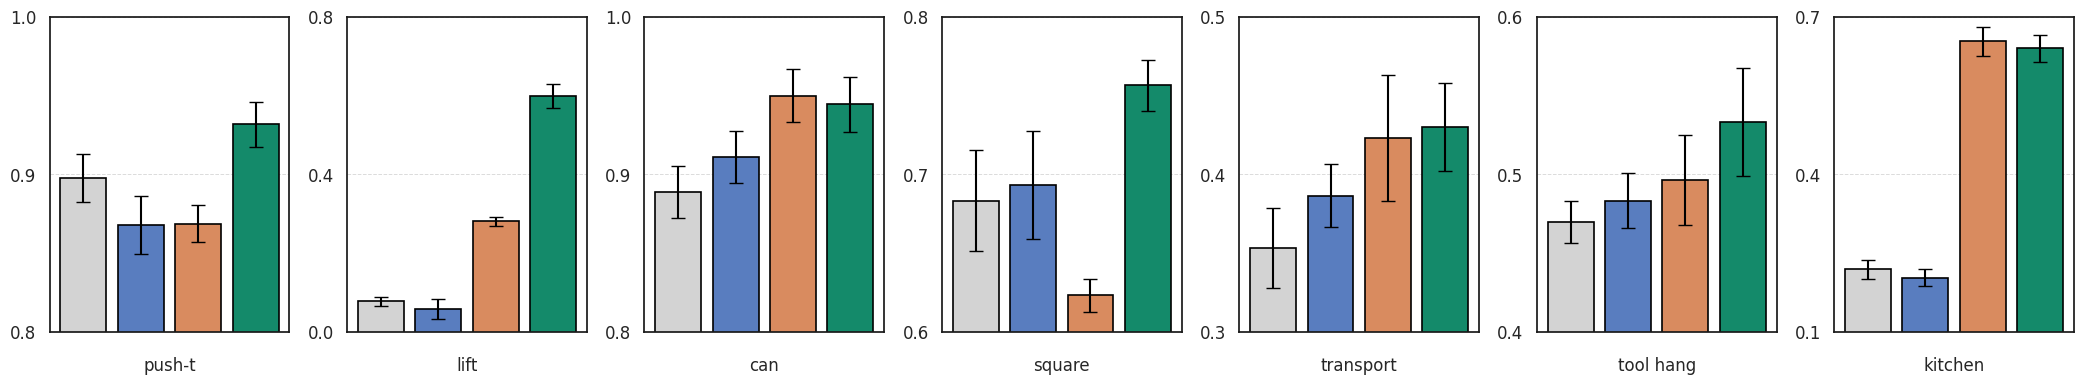

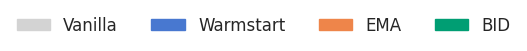

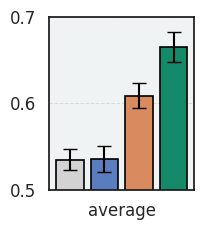

In [3]:
import matplotlib.ticker as plticker
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, LinearLocator

# Set default font size
plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

foldername = 'result'
all_summary = []

# Define tasks and corresponding metrics
tasks_metrics_ylim = [
    ('pusht', 'test/mean_score', [0.78, 0.96]),
    ('lift', 'test/mean_score', [0.04, 0.76]),
    ('can', 'test/mean_score', [0.84, 0.96]),
    ('square', 'test/mean_score', [0.6, 0.8]),
    ('transport', 'test/mean_score', [0.3, 0.5]),
    ('tool_hang', 'test/mean_score', [0.44, 0.64]),
    ('kitchen', 'test/p_4', [0.1, 0.7]),
]

# Create a figure with horizontal subplots
n_tasks = len(tasks_metrics_ylim)
fig, axs = plt.subplots(1, n_tasks, figsize=(n_tasks * 3, 4))  # Adjust figsize as needed

# Loop through each task and metric
for i, (task, metric, ylim) in enumerate(tasks_metrics_ylim):

    patterns = [
        f'../{foldername}/{task}/*/*/*/eval_*_random_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_warmstart_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_ema_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_bid_*.json',
    ]
    df = load_data(patterns, metric)

    # Filtering
    df = df[df['noise'] == 0.0]
    df = df[df['nsample'].isin([1, 16])]  # only consider default hyperparamter
    df = df[~((df['method'] == 'bid') & (df['ah'] == 8))]

    # Add 'name' column based on conditions
    df['name'] = df['method']
    df.loc[(df['method'] == 'random') & (df['ah'] == 1), 'name'] = 'closed'
    df.loc[(df['method'] == 'random') & (df['ah'] == 8), 'name'] = 'open'

    # Explode the 'metric' column to ensure scalar values
    df = df.explode(metric)
    df[metric] = pd.to_numeric(df[metric], errors='coerce')

    # Calculate mean and standard deviation for each 'name' group
    summary_df = df.groupby('name')[metric].agg(mean='mean', std='std').reset_index()

    # Define the preferred order of bars and reorder summary_df accordingly
    order = ['open', 'closed', 'warmstart', 'ema', 'bid']
    summary_df = summary_df.set_index('name').reindex(order).reset_index()

    # Rename the selected rows
    rename_map = {
        'closed': 'Vanilla',
        'warmstart': 'Warmstart',
        'ema': 'EMA',
        'bid': 'BID'
    }
    summary_df['name'] = summary_df['name'].replace(rename_map)

    # Define the color palette for different categories
    colors = {
        'Vanilla': 'lightgray',
        'Warmstart': color_palette[0],
        'EMA': color_palette[1],
        'BID': color_palette[2],
    }

    # Define the name to exclude
    name_to_exclude = 'open'

    # Filter the summary_df to exclude the specified name
    summary_df = summary_df[summary_df['name'] != name_to_exclude]

    # Create bar plot in the current subplot
    ax = axs[i]
    barplot = sns.barplot(data=summary_df, x='name', y='mean', hue='name', order=summary_df['name'], palette=colors,
                          capsize=0.1, width=0.8, edgecolor='black', linewidth=1.2, ax=ax)

    # Get x positions of the bars
    x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]
    lerr = np.maximum(summary_df['std'] * 0.5, 0.01)
    uerr = np.maximum(summary_df['std'] * 0.5, 0.01)

    # Add error bars manually
    ax.errorbar(x=x_positions, y=summary_df['mean'], yerr=[lerr, uerr], fmt='none', c='black', capsize=5)

    # Adding gridlines for better readability (remove vertical lines)
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.grid(axis='x', visible=False)

    # Customize plot
    ymin = ylim[0]
    ymax = ylim[1]
    ax.set_ylim(ymin, ymax)

    ax.spines['top'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['bottom'].set_color('k')

    ax.set_xticks([])  # Remove x-ticks
    ax.set_xticklabels([])  # Remove x-tick labels
    ax.set_xlabel('')  # Remove x-label
    ax.set_ylabel('')  # Remove y-label

    task = task.replace("_", " ")
    title = 'push-t' if task == 'pusht' else task
    ax.set_title(title, y=-0.15)

    yticks = np.linspace(ymin, ymax, num=3)  # Adjust `num` to control the number of ticks
    ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    summary_df['task'] = task
    all_summary.append(summary_df)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()



# Set legend
label = list(rename_map.values())
color = list(colors.values())

# Create handles for the legend using patches (for barplots)
handles = [
    mpatches.Patch(color=c, label=l)
    for c, l in zip(color, label)
]

# Create a new figure for the legend
fig, ax = plt.subplots(figsize=(2, 0.2))  # Adjust height for better visibility
fig.legend(handles, label, loc='center', fontsize=12, ncol=len(label), frameon=False)  # Remove the border
ax.axis('off')

# # Optionally save the figure
# fname = f'../figures/dp_legend.png'
# plt.savefig(fname, format='png', dpi=300, bbox_inches='tight', pad_inches=0.0)

# Display the legend
plt.show()




# All summary
all_summary_df = pd.concat(all_summary, ignore_index=True)

# Calculate average mean and std for each 'name' across all tasks
average_summary_df = all_summary_df.groupby('name').agg(mean=('mean', 'mean'), std=('std', 'mean')).reset_index()

# # Define the preferred order of bars and reorder average_summary_df accordingly
order = ['Vanilla', 'Warmstart', 'EMA', 'BID']
average_summary_df = average_summary_df.set_index('name').reindex(order).reset_index()

# Create aggregated bar plot for average across all tasks
fig, ax = plt.subplots(figsize=(2.2, 2.5))  # Adjusted size
avg_barplot = sns.barplot(data=average_summary_df, x='name', y='mean', hue='name', order=average_summary_df['name'], palette=colors,
                          capsize=0.1, width=0.8, edgecolor='black', linewidth=1.2, ax=ax)

# Get x positions of the bars
x_positions = [p.get_x() + p.get_width() / 2 for p in avg_barplot.patches]

# Add error bars manually
plt.errorbar(x=x_positions, y=average_summary_df['mean'], yerr=average_summary_df['std'] * 0.5,
             fmt='none', c='black', capsize=5)

# Adding gridlines for better readability (remove vertical lines)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
ax.grid(axis='x', visible=False)
ax.set_facecolor('#F0F3F4') 

# Customize plot
avg_barplot.set_ylabel('Success Rate', fontsize=12)
ymin = average_summary_df['mean'].min() - average_summary_df['std'].max()
ymax = average_summary_df['mean'].max() + average_summary_df['std'].max()
avg_barplot.set_ylim(ymin, ymax)

plt.gca().spines['top'].set_color('k')
plt.gca().spines['right'].set_color('k')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['bottom'].set_color('k')

# Customize plot
ax.set_xticks([])  # Remove x-ticks
ax.set_xticklabels([])  # Remove x-tick labels
ax.set_xlabel('')  # Remove x-label
ax.set_ylabel('')  # Remove x-label
ax.set_title('average', y=-0.2)

yticks = np.linspace(ymin, ymax, num=3)  # Adjust `num` to control the number of ticks
ax.set_yticks(yticks)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Tight layout to avoid clipping
plt.tight_layout()

# # Optionally save the figure
# fname = f'../figures/dp_average.png'
# plt.savefig(fname, format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

# display(average_summary_df)

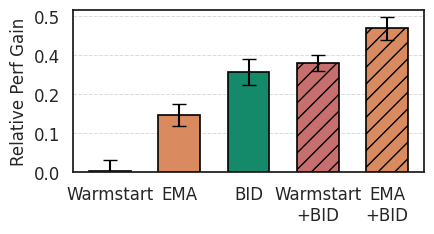

,name,mean,std,relative_mean,relative_std
1,Warmstart,0.521,0.038,0.003,0.073
2,EMA,0.615,0.038,0.182,0.072
3,BID,0.686,0.044,0.321,0.085
4,Warmstart\n+BID,0.702,0.028,0.350,0.054
5,EMA\n+BID,0.759,0.037,0.461,0.072


In [4]:
# Define tasks and corresponding metrics
tasks_and_metrics = [
    ('pusht', 'test/mean_score'),
    ('lift', 'test/mean_score'),
    ('can', 'test/mean_score'),
    ('square', 'test/mean_score'),
    ('transport', 'test/mean_score'),
    ('tool_hang', 'test/mean_score'),
    ('kitchen', 'test/p_4'),
]

# Define the color palette for different categories
colors = {
    'warmstart': color_palette[3],
    'ema': color_palette[1],
    'bid': color_palette[2],
    'cwarm': color_palette[3],
    'cma': color_palette[1],
}

all_summary = []
# Loop through each task and metric
for task, metric in tasks_and_metrics:

    patterns = [
        f'../{foldername}/{task}/*/*/*/eval_*_random_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_warmstart_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_ema_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_bid_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_cwarm_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_cma_*.json',
    ]
    df = load_data(patterns, metric)

    # Filtering
    df = df[df['noise'] == 0.0]
    df = df[df['nsample'].isin([1, 16])]    
    df = df[~((df['method'] == 'bid') & (df['ah'] == 8))]

    # Add 'name' column based on conditions
    df['name'] = df['method']
    df.loc[(df['method'] == 'random') & (df['ah'] == 1), 'name'] = 'closed'
    df.loc[(df['method'] == 'random') & (df['ah'] == 8), 'name'] = 'open'

    # Explode the 'metric' column to ensure scalar values
    df = df.explode(metric)
    df[metric] = pd.to_numeric(df[metric], errors='coerce')

    # Calculate mean and standard deviation for each 'name' group
    summary_df = df.groupby('name')[metric].agg(mean='mean', std='std').reset_index()

    # Define the preferred order of bars and reorder summary_df accordingly
    order = ['closed', 'warmstart', 'ema', 'bid', 'cwarm', 'cma']
    summary_df = summary_df.set_index('name').reindex(order).reset_index()

    summary_df['task'] = task
    all_summary.append(summary_df)

# Combine all summaries
all_summary_df = pd.concat(all_summary, ignore_index=True)

# Extract the mean value for the 'closed' category
closed_mean = all_summary_df[all_summary_df['name'] == 'closed']['mean'].mean()

# Calculate relative gain for each task and add it to the all_summary_df
all_summary_df['relative_gain'] = all_summary_df['mean'].apply(lambda x: (x - closed_mean) / closed_mean)

# Calculate average mean, std, and relative gain for each 'name' across all tasks
average_summary_df = all_summary_df.groupby('name').agg(
    mean=('mean', 'mean'),
    std=('std', 'mean'),
    relative_gain_mean=('relative_gain', 'mean'),
    relative_gain_std=('relative_gain', 'std')
).reset_index()

# Reorder average_summary_df accordingly
order = ['closed', 'warmstart', 'ema', 'bid', 'cwarm', 'cma']
average_summary_df = average_summary_df.set_index('name').reindex(order).reset_index()


# Calculate average mean and std for each 'name' across all tasks
average_summary_df = all_summary_df.groupby('name').agg(mean=('mean', 'mean'), std=('std', 'mean')).reset_index()

# Calculate relative gain compared with 'closed' and add it to the summary dataframe
average_summary_df['relative_mean'] = average_summary_df['mean'].apply(lambda x: x / closed_mean - 1)
average_summary_df['relative_std'] = average_summary_df['std'].apply(lambda x: x / closed_mean)

# Reorder average_summary_df accordingly
average_summary_df = average_summary_df.set_index('name').reindex(order).reset_index()
average_summary_df = average_summary_df[average_summary_df['name'] != 'closed']
palette = [colors[name] for name in order if name != 'closed']

# Rename the selected rows
rename_map = {
    'warmstart': 'Warmstart',
    'ema': 'EMA',
    'bid': 'BID',
    'cwarm': 'Warmstart\n+BID',
    'cma': 'EMA\n+BID',
}
average_summary_df['name'] = average_summary_df['name'].replace(rename_map)

# Create aggregated bar plot for relative mean and std across all tasks
fig, ax = plt.subplots(figsize=(4.5, 2.5))  # Adjust the size as needed
avg_barplot = sns.barplot(data=average_summary_df, x='name', y='relative_mean', hue='name', order=average_summary_df['name'], palette=palette,
                         capsize=0.1, width=0.6, edgecolor='black', linewidth=1.2)

# Add hatches to bars
hatches = ["", "", "", "//", "//"]
for i, bar in enumerate(avg_barplot.patches):
    bar.set_hatch(hatches[i])

# Get x positions of the bars
x_positions = [p.get_x() + p.get_width() / 2 for p in avg_barplot.patches]

# Add error bars manually
plt.errorbar(x=x_positions, y=average_summary_df['relative_mean'], yerr=average_summary_df['relative_std'] * 0.5,
             fmt='none', c='black', capsize=5)

# Adding gridlines for better readability (remove vertical lines)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
ax.grid(axis='x', visible=False)

# Customize plot
avg_barplot.set_ylabel(f'Relative Perf Gain', fontsize=12)
ymin=0.0
ymax=0.52
avg_barplot.set_ylim(ymin, ymax)
yticks = np.linspace(ymin, 0.5, num=5)  # Adjust `num` to control the number of ticks
ax.set_yticks(yticks)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


plt.gca().spines['top'].set_color('k')
plt.gca().spines['right'].set_color('k')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['bottom'].set_color('k')

ax.set_xlabel('')
ax.set_ylabel('Relative Perf Gain', fontsize=12)

# Tight layout to avoid clipping
plt.tight_layout()

# # Optionally save the figure
line_figname = '../figures/complement.png'
plt.savefig(line_figname, format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()
display(average_summary_df)

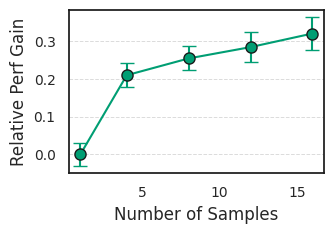

In [5]:
all_summary = []
# Loop through each task and metric
for task, metric in tasks_and_metrics:

    patterns = [
        f'../{foldername}/{task}/*/*/*/eval_*_random_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_bid_*.json',
    ]
    df = load_data(patterns, metric)
    
    # Filtering
    df = df[df['noise'] == 0.0]
    df = df[df['ah'] == 1]
    df = df[df['method'].isin(['bid', 'random'])]
    
    # summary
    summary_df = df.groupby('nsample').agg(mean=(metric, 'mean'), std=(metric, 'std')).reset_index()
    summary_df['task'] = task
    all_summary.append(summary_df)

# All summary
all_summary_df = pd.concat(all_summary, ignore_index=True)

# Calculate average mean and std for each 'nsample' across all tasks
average_summary_df = all_summary_df.groupby('nsample').agg(mean=('mean', 'mean'), std=('std', 'mean')).reset_index()

# Define the preferred order of bars and reorder average_summary_df accordingly
order = all_summary_df['nsample'].unique()  # Assuming you want to use all unique 'nsample' values in order
order.sort()  # Sort the order if needed
average_summary_df = average_summary_df.set_index('nsample').reindex(order).reset_index()

# Compute the reference mean value for nsample=1
reference_mean = average_summary_df.loc[average_summary_df['nsample'] == 1, 'mean'].values[0]

# Compute the relative gain compared to nsample=1
average_summary_df['relative_gain'] = (average_summary_df['mean'] - reference_mean) / reference_mean
average_summary_df['relative_std'] = average_summary_df['std'] / reference_mean

# Sort the dataframe by the extracted number (if needed)
average_summary_df = average_summary_df.sort_values(by='nsample')

# Create the line plot for relative gain
fig, ax = plt.subplots(figsize=(3.5, 2.5))  # Adjust the size as needed

# Adding error bars using plt.errorbar for the relative gain
ax.errorbar(average_summary_df['nsample'], average_summary_df['relative_gain'], 
            yerr=average_summary_df['relative_std'] * 0.5, fmt='o', 
            capsize=5,
           color=color_palette[2]) 

line_plot = sns.lineplot(
    x='nsample', 
    y='relative_gain', 
    data=average_summary_df,
    marker='o',
    color=color_palette[2],
    markersize=7,
    markeredgecolor="k",
    markeredgewidth=2,
    ax=ax,
)

# Adding labels and title with improved font size
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Relative Perf Gain', fontsize=12)
ax.tick_params(axis='both', labelsize=10)

# Adding gridlines for better readability (remove vertical lines)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
ax.grid(axis='x', visible=False)

plt.gca().spines['top'].set_color('k')
plt.gca().spines['right'].set_color('k')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['bottom'].set_color('k')

# Tight layout to avoid clipping
plt.tight_layout()

# # Optionally save the figure
line_figname = f'../figures/scaling.png'
plt.savefig(line_figname, format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

# display(average_summary_df)


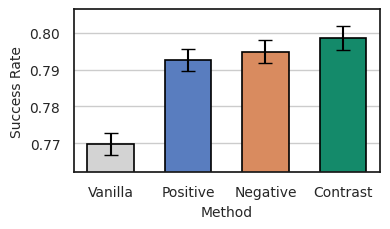

In [6]:
# Set default font size for all text elements in your plots
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=10)     # font size of the axes title
plt.rc('axes', labelsize=10)     # font size of the x and y labels
plt.rc('xtick', labelsize=10)    # font size of the x tick labels
plt.rc('ytick', labelsize=10)    # font size of the y tick labels
plt.rc('legend', fontsize=10)    # legend font size


# Rename the selected rows
rename_map = {
    'open': 'Vanilla',
    'positive': 'Positive',
    'negative': 'Negative',
    'contrast': 'Contrast'
}

# Define the color palette for different categories
colors = {
    'open': 'lightgray',
    'positive': color_palette[0],
    'negative': color_palette[1],
    'contrast': color_palette[2],
}

# Define the preferred order of bars
order = ['open', 'positive', 'negative', 'contrast']

# Generate color palette for the current order
palette = [colors[name] for name in order]

all_summary = []

# Loop through each task and metric
for task, metric in tasks_and_metrics:
    patterns = [
        f'../{foldername}/{task}/*/*/*/eval_*_random_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_positive_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_negative_*.json',
        f'../{foldername}/{task}/*/*/*/eval_*_contrast_*.json',
    ]
    df = load_data(patterns, metric)

    # Filtering
    df = df[df['noise'] == 0.0]
    df = df[df['nsample'].isin([1, 16])]
    df = df[df['ah'].isin([8])]

    # Add 'name' column based on conditions
    df['name'] = df['method']
    df.loc[(df['method'] == 'random') & (df['ah'] == 1), 'name'] = 'closed'
    df.loc[(df['method'] == 'random') & (df['ah'] == 8), 'name'] = 'open'

    # Explode the 'metric' column to ensure scalar values
    df = df.explode(metric)
    df[metric] = pd.to_numeric(df[metric], errors='coerce')

    summary_df = df.groupby('name').agg(mean=(metric, 'mean'), std=(metric, 'std')).reset_index()
    summary_df['task'] = task

    # Reorder summary_df accordingly
    summary_df['name'] = summary_df['name'].replace(rename_map)
    summary_df = summary_df.set_index('name').reindex(rename_map.values()).reset_index()

    all_summary.append(summary_df)

# all summary
all_summary_df = pd.concat(all_summary, ignore_index=True)

# Calculate average mean and std for each 'name' across all tasks
average_summary_df = all_summary_df.groupby('name').agg(mean=('mean', 'mean'), std=('std', 'mean')).reset_index()

# Reorder average_summary_df accordingly
average_summary_df = average_summary_df.set_index('name').reindex(rename_map.values()).dropna().reset_index()

# Create bar plot without error bars
fig, ax = plt.subplots(figsize=(4, 2.4))  # Adjust the size as needed
barplot = sns.barplot(data=average_summary_df, x='name', y='mean', hue='name', order=average_summary_df['name'], palette=palette, capsize=0.1,
                      width=0.6,
                      edgecolor='black',
                      linewidth=1.2)

# Get x positions of the bars
x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]

# Add error bars manually
plt.errorbar(x=x_positions, y=average_summary_df['mean'], yerr=average_summary_df['std'] / len(tasks_and_metrics),
             fmt='none', c='black', capsize=5)

# Customize plot
barplot.set_ylim(average_summary_df['mean'].min() * 0.99, average_summary_df['mean'].max() * 1.01)

plt.gca().spines['top'].set_color('k')
plt.gca().spines['right'].set_color('k')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['bottom'].set_color('k')

ax.set_xlabel('Method')  # Remove x-label
ax.set_ylabel('Success Rate')

# Tight layout to avoid clipping
plt.tight_layout()

# # Optionally save the figure
# figname = '../figures/contrast.png'
# plt.savefig(figname, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()
